In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import folium
import geopandas as gpd

from data_prep import data_prep
import get_model
import utils

seed = 42
np.random.seed(seed)

In [2]:
# Read datasets
df_bio = pd.read_csv('dataset\Biomass_History.csv')
df_dist = pd.read_csv('dataset\Distance_Matrix.csv')
submission = pd.read_csv('dataset\sample_submission.csv')
df_ext = pd.read_excel('dataset\External_Data.xlsx')
df_real = pd.read_csv('dataset\Biomass_Private.csv')

data_loader = data_prep()
data_loader.create_images(width=80, height=64)
selected_pix = data_loader.selected_pix
images = data_loader.get_images()

## Forecast - Data Prep

In [3]:
# Expand dfbio dataset
df_bio_long = pd.melt(df_bio, id_vars=['Index','Latitude','Longitude'], var_name='Year', value_name='Bio')
df_bio_long['Year'] = df_bio_long['Year'].astype(int)
df_bio_long['Bio'] = df_bio_long['Bio'].astype(float)

years = [str(year) for year in range(2010,2017+1)]
df_bio['mean_bio'] = df_bio.apply(lambda x: np.mean(x[years]),axis=1)

In [4]:
# Aggregate external dataset
df_ext_annual = df_ext.groupby('Year').agg({
    "Avg_Temp" : "mean",
    "Min_Temp" : "min",
    "Max_Temp" : "max",
    "Rainfall" : "sum",
    "Rain_Days" : "sum",
    "Cloud" : "mean",
    "Humidity" : "mean",
    "Sun_Hours" : "sum",
    "Sun_Days" : "sum",
    "UV_Index" : "mean",
    "Pressure": "mean",
    "Avg_Gust": "mean",
    "Max_Wind": "max",
    "Avg_Wind": "mean",
}).reset_index()

In [5]:
train_coords = df_bio.drop_duplicates(subset = ['Latitude', 'Longitude'])
geometry = gpd.points_from_xy(train_coords.Longitude, train_coords.Latitude)
geo_df = gpd.GeoDataFrame(
    train_coords[["Latitude", "Longitude"]], geometry=geometry
)

# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Define a colormap (you can choose any colormap from matplotlib)
colormap = plt.cm.jet

# Normalize 'Value' column to fit between 0 and 1 for colormap
norm = plt.Normalize(vmin=train_coords['mean_bio'].min(), vmax=train_coords['mean_bio'].max())

# Iterate through list and add a marker for each location
for coordinates, value in zip(geo_df_list, train_coords['mean_bio']):
    # Get the color from the colormap
    color = plt.cm.colors.to_hex(colormap(norm(value)))
    
    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            color = color),
        )   

all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

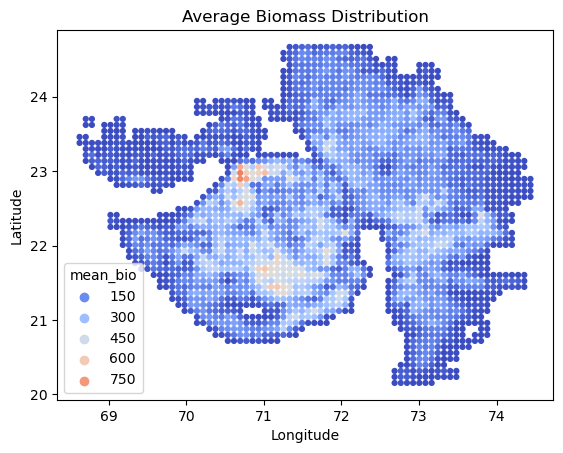

In [6]:
sns.scatterplot(data=df_bio, x='Longitude', y='Latitude', hue='mean_bio', palette='coolwarm', hue_norm=(0, 1000), s=20, linewidth=0)
plt.title('Average Biomass Distribution')
plt.show()

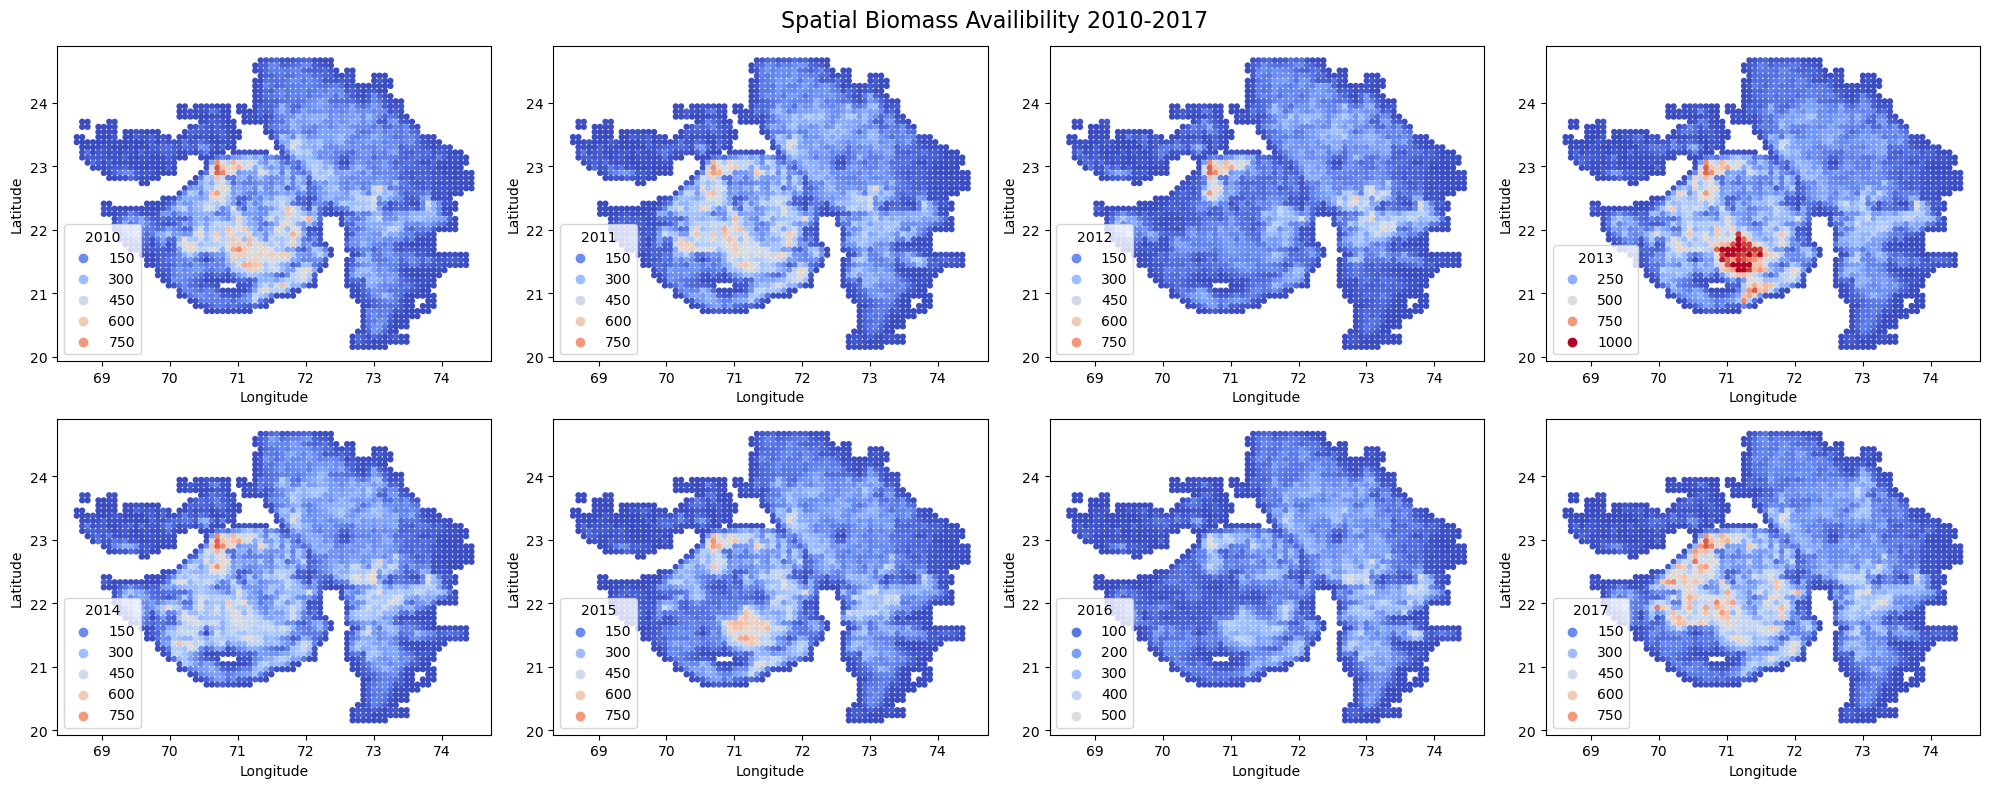

In [7]:
# Initial analysis
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()) :
    sns.scatterplot(data = df_bio, x='Longitude',y='Latitude', hue=str(2010+i), ax=ax, palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0)

fig.suptitle('Spatial Biomass Availibility 2010-2017', fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
df_bio_log = df_bio.copy()
df_bio_log[years] = np.log1p(df_bio_log[years])

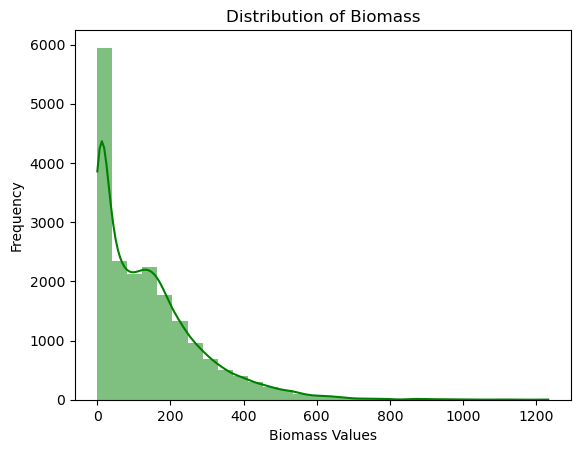

In [9]:
sns.histplot(df_bio_long['Bio'], bins=30, kde=True, color='green', edgecolor='none')
# Add title and axis labels
plt.title('Distribution of Biomass')
plt.xlabel('Biomass Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()

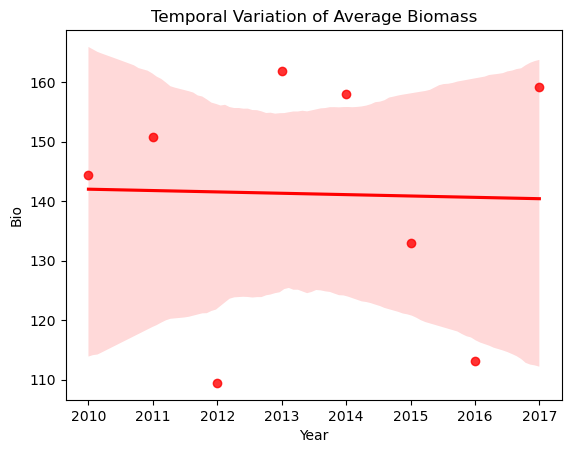

In [10]:
sns.regplot(data=df_bio_long.groupby(by='Year')['Bio'].mean().reset_index(),x='Year',y='Bio',color='red')
# Add title and axis labels
plt.title('Temporal Variation of Average Biomass')
plt.xlabel('Year')
plt.ylabel('Bio')

# Show the plot
plt.show()

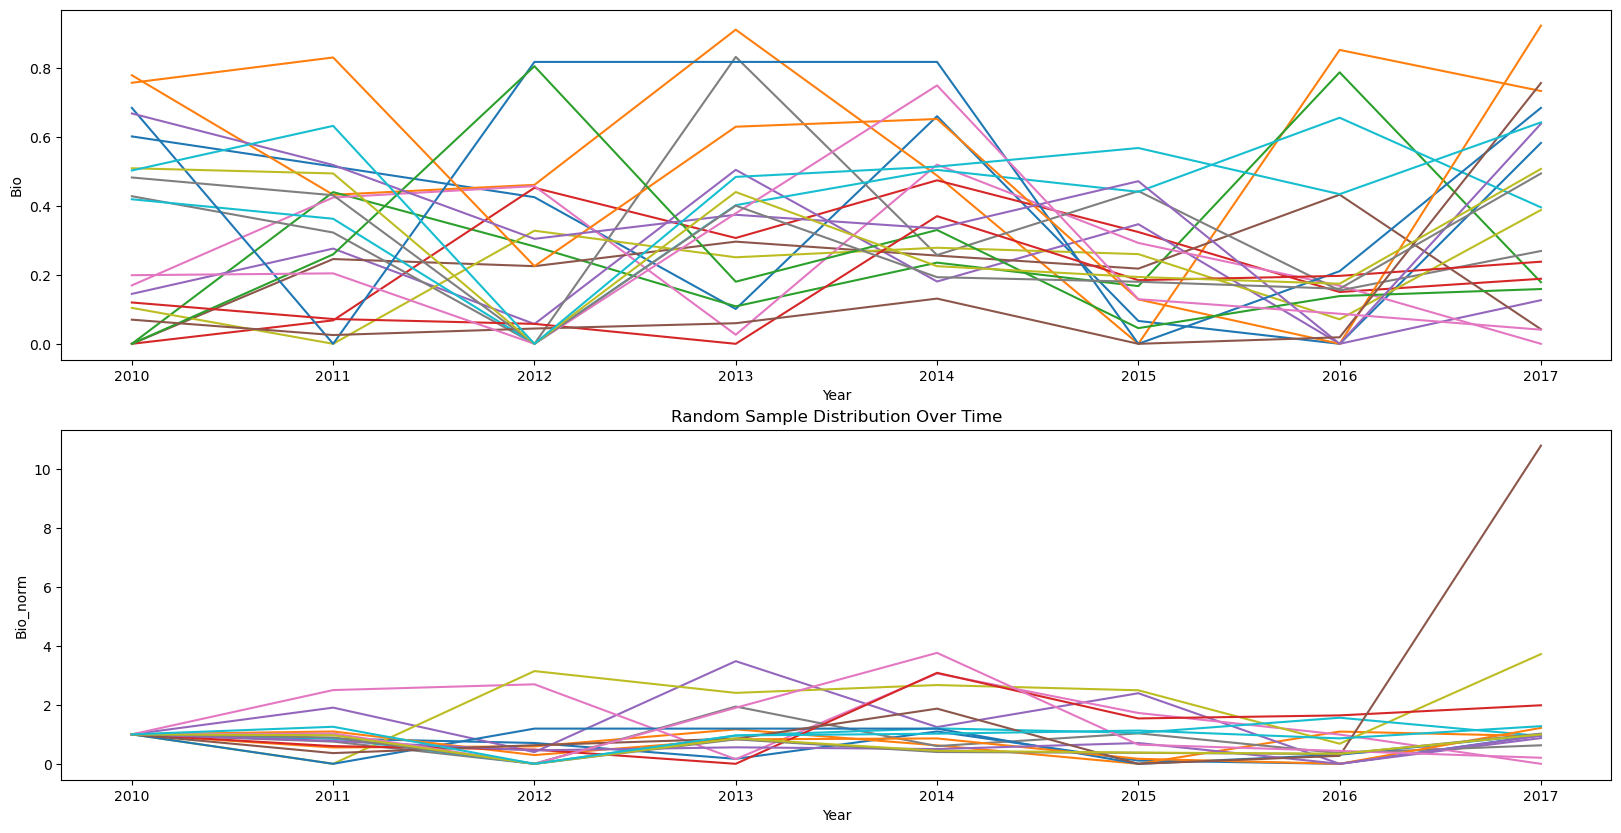

In [11]:
# Create dataframe for timeseries clustering
df_ts = df_bio.drop(columns=['Latitude','Longitude','mean_bio'])
year_cols = df_ts.columns[1:]

# Create a normalized dataframe and expand
df_ts_norm = df_ts.copy()
df_ts_norm[year_cols] = df_ts_norm.apply(lambda row: (row[year_cols] - row[year_cols].min())/row[year_cols].max(), axis=1)
df_ts_long = pd.melt(df_ts_norm, id_vars=['Index'], var_name='Year', value_name='Bio')

fig, axes = plt.subplots(nrows=2, figsize=(20, 10))

# Selecting 100 random unique indices
random_indices = np.random.choice(df_ts_long['Index'].unique(), size=20, replace=False)

for i in random_indices:
    sns.lineplot(data=df_ts_long[df_ts_long['Index'] == i], x='Year', y='Bio', ax=axes[0])
    ts = df_ts_long[df_ts_long['Index'] == i].groupby('Year')['Bio'].mean()
    ts = ts/ts.loc['2010']
    sns.lineplot(ts, ax=axes[1])
    
# Adding title and changing y-axis label
plt.title('Random Sample Distribution Over Time')
plt.ylabel('Bio_norm')

plt.show()

In [12]:
df_bio_long_log = df_bio_long.copy()
df_bio_long_log['Bio_log'] = np.log1p(df_bio_long_log['Bio'])

In [13]:
past_count = 3
df_temporal = df_bio_long.copy()
for i in range(1,past_count+1):
        df_lag=df_bio_long.copy()[['Index','Year','Bio']]
        df_lag['Year'] = df_lag['Year']+i
        df_temporal = df_temporal.merge(df_lag, on=['Index', 'Year'], how='left',suffixes=('',f'_plus{i}'))

df_temporal.dropna(inplace=True)

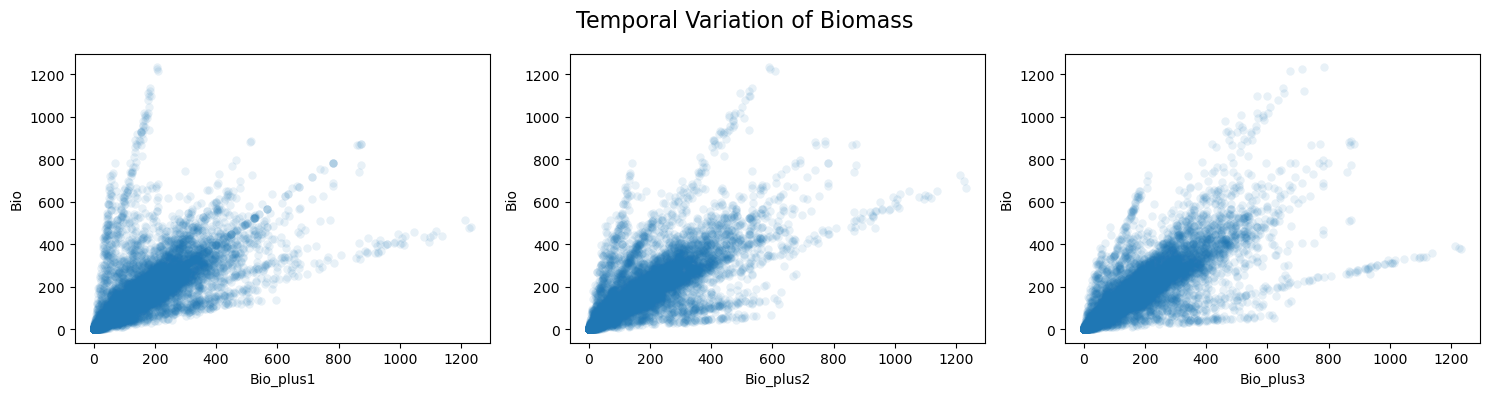

In [14]:
# Initial analysis
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

for i, ax in enumerate(axes.flatten()) :
    sns.scatterplot(data = df_temporal, x='Bio_plus'+str(i+1),y='Bio', ax=ax, alpha=0.1, linewidth=0)
    # ax.set_xlim(4, 7)
    # ax.set_ylim(4, 7)

fig.suptitle('Temporal Variation of Biomass', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
n_closest = 5
df_closest = pd.DataFrame(df_bio['Index'])
df_closest['closest'] = df_bio['Index'].apply(lambda x: df_dist[str(x)].nsmallest(n_closest).index.tolist())

for i in range(n_closest):
    df_closest['closest_'+str(i)] = df_closest.apply(lambda x: x['closest'][i] ,axis=1)

df_spatial = df_bio_long.copy()
for i in range(n_closest):
    df_spatial['closest_'+str(i)] = df_bio_long.apply(lambda x:
                                                      np.nan if int(x['Year']) == 2010 else
                                                      df_bio.loc[df_closest.loc[int(x['Index']),'closest_'+str(i)],str(int(x['Year'])-1)],
                                                      axis=1)
df_spatial.dropna(inplace=True)

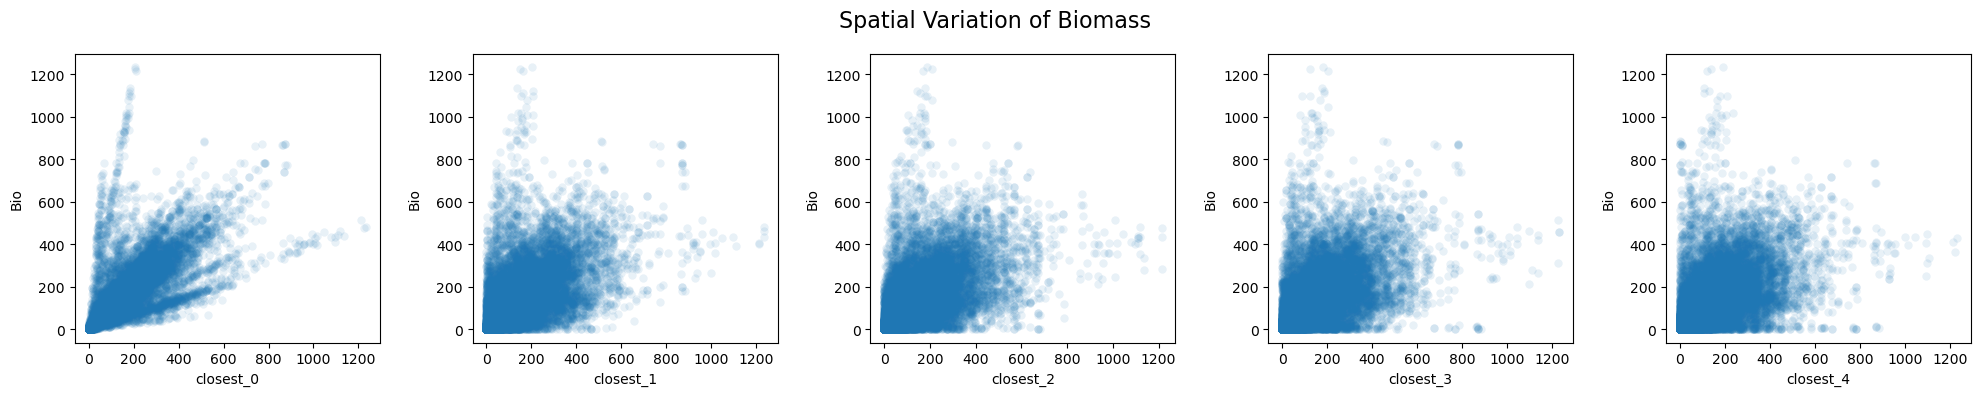

In [16]:
# Initial analysis
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

for i, ax in enumerate(axes.flatten()) :
    sns.scatterplot(data = df_spatial, x='closest_'+str(i) ,y='Bio', ax=ax, alpha=0.1, linewidth=0)
    # ax.set_xlim(4, 7)
    # ax.set_ylim(4, 7)

fig.suptitle('Spatial Variation of Biomass', fontsize=16)
plt.tight_layout()
plt.show()

In [17]:
df_spatiotemporal = pd.merge(left=df_temporal,right=df_spatial,how='inner')
df_spatiotemporal.drop('closest_0',axis=1,inplace=True)

In [18]:
df_spatiotemporal

Index  Latitude  Longitude  Year        Bio  Bio_plus1  Bio_plus2  \
0          0  24.66818   71.33144  2013   6.023070   9.202181   8.868568   
1          1  24.66818   71.41106  2013  21.634459  25.866415  28.551348   
2          2  24.66818   71.49069  2013  53.003735  56.982258  66.111168   
3          3  24.66818   71.57031  2013  63.160561  78.956543  80.821304   
4          4  24.66818   71.64994  2013  17.899586  21.928144  19.327524   
...      ...       ...        ...   ...        ...        ...        ...   
12085   2413  20.15456   72.84432  2017   5.321604   6.419223   5.301668   
12086   2414  20.15456   72.92394  2017   0.120626   0.145785   0.122467   
12087   2415  20.15456   73.00357  2017   0.038879   0.046989   0.039473   
12088   2416  20.15456   73.08319  2017   1.304297   1.576338   1.324201   
12089   2417  20.15456   73.16282  2017   0.226953   0.274289   0.230417   

       Bio_plus3   closest_1   closest_2  closest_3   closest_4  
0       8.475744   58.226315   25.866415  81.218788   56.982258  
1      24.029778   58.226315   56.982258   9.202181   81.218788  
2      44.831635  149.984787   25.866415  81.218788   58.226315  
3      59.974419   21.928144  105.671814  90.009483  149.984787  
4      14.653370   90.009483   26.003826  78.956543  105.671814  
...          ...         ...         ...        ...         ...  
12085   5.113997   16.318977    0.069423  56.108021    0.145785  
12086   0.121749    0.046989    6.419223  27.987146   56.108021  
12087   0.039241    1.576338    0.145785   3.582397    6.639752  
12088   1.316443    0.274289    0.046989   3.582397    6.639752  
12089   0.229067    1.576338    0.046989   3.582397    6.639752  

[12090 rows x 12 columns]

In [19]:
spatial_features = ['closest_'+str(i) for i in range(1,5)]
temporal_features = ['Bio_plus'+str(i) for i in range(1,4)]

<Axes: >

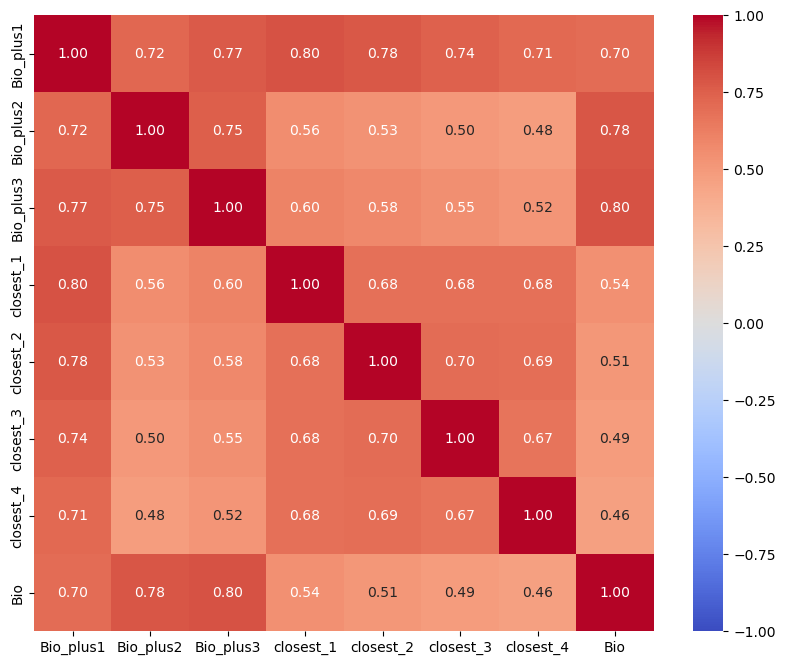

In [20]:
corr_value = df_spatiotemporal[temporal_features+spatial_features+['Bio']].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_value, vmin=-1,vmax=1,cmap='coolwarm', annot=True, fmt='.2f')

In [21]:
from minisom import MiniSom
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler

In [22]:
class KmeansDBAClassifier:
    def __init__(self, x=4, y=6):
        self.x = x
        self.y = y
        self.clusters = self.x*self.y
    
    def train(self, dfts_norm):
        self.df = dfts_norm.copy()
        self.series_data = dfts_norm.drop(columns=['Index']).values

        self.tskm = TimeSeriesKMeans(n_clusters=self.clusters, metric="dtw", random_state=42)
        self.labels = self.tskm.fit_predict(self.series_data)

    def get_silhouette_score(self):
        silhouette_avg = silhouette_score(self.series_data, self.labels)
        return silhouette_avg
    
    def plot_cluster(self):
        fig, axes = plt.subplots(self.y, self.x,figsize=(self.x*5,self.y*5))
        for y in range(self.y):
            for x in range(self.x):
                cluster = (x,y)
                cluster_series = self.series_data[self.labels==(x*5 + y)]
                for series in cluster_series:
                    axes[cluster].plot(series,c="gray",alpha=0.5)
                axes[cluster].plot(dtw_barycenter_averaging(np.vstack(cluster_series)),c="red")
            
        plt.tight_layout()
        plt.show()

    def get_df_label(self):
        dflabel = pd.concat([self.df['Index'],pd.Series(self.labels, name='Label')], axis=1)
        return dflabel
    
    def plot_distribution(self):
        df = self.get_df_label()
        df['Label'].value_counts().plot(kind='bar', figsize=(15,4), title='Distribution')

In [23]:
class KmeansClassifier:
    def __init__(self, x=4, y=6):
        self.x = x
        self.y = y
        self.clusters = self.x*self.y
    
    def train(self, dfts_norm):
        self.df = dfts_norm.copy()
        self.series_data = dfts_norm.drop(columns=['Index']).values

        self.km = KMeans(n_clusters=self.x*self.y, n_init=30, random_state=42)
        self.labels = self.km.fit_predict(self.series_data)

    def get_silhouette_score(self):
        silhouette_avg = silhouette_score(self.series_data, self.labels)
        return silhouette_avg
    
    def plot_cluster(self):
        fig, axes = plt.subplots(self.y, self.x,figsize=(self.x*5,self.y*5))
        for y in range(self.y):
            for x in range(self.x):
                cluster = (y,x)
                cluster_series = self.series_data[self.labels==(x*self.x + y)]
                for series in cluster_series:
                    axes[cluster].plot(series,c="gray",alpha=0.5)
                axes[cluster].plot(dtw_barycenter_averaging(np.vstack(cluster_series)),c="red")
            
        plt.tight_layout()
        plt.show()

    def get_df_label(self):
        dflabel = pd.concat([self.df['Index'],pd.Series(self.labels, name='Label')], axis=1)
        return dflabel
    
    def plot_distribution(self):
        df = self.get_df_label()
        df['Label'].value_counts().plot(kind='bar', figsize=(15,4), title='Distribution')

In [24]:
class SOMClassifier:
    def __init__(self, som_x=5, som_y=5, learning_rate=0.05):
        self.som_x = som_x
        self.som_y = som_y
        self.learning_rate = learning_rate

    def train(self, dfts_norm):
        series_data = dfts_norm.drop(columns=['Index']).values

        self.som = MiniSom(self.som_x, self.som_y, input_len=series_data.shape[1], learning_rate=self.learning_rate, random_seed=42)
        self.som.random_weights_init(series_data)

        num_epochs = 50000
        self.som.train_random(series_data, num_epochs)

        self.winners = self.som.win_map(series_data)

        cluster_indices = list(self.winners.keys())
        self.winners_indexed = {f"Cluster {i+1}": self.winners[cluster_indices[i]] for i in range(len(cluster_indices))}

        self.list_of_series = np.array([series for series_list in self.winners_indexed.values() for series in series_list])

        self.cluster_labels = []
        for cluster, series_list in self.winners_indexed.items():
            self.cluster_labels.extend([cluster] * len(series_list))

        self.cluster_labels = np.array(self.cluster_labels)

    def get_silhouette_score(self):
        silhouette_avg = silhouette_score(self.list_of_series, self.cluster_labels)
        return silhouette_avg
    
    def plot_cluster(self):
        fig, axs = plt.subplots(self.som_x,self.som_y,figsize=(min(self.som_x,self.som_y)*5,max(self.som_x,self.som_y)*5))
        for x in range(self.som_x):
            for y in range(self.som_y):
                cluster = (x,y)
                if cluster in self.winners.keys():
                    for series in self.winners[cluster]:
                        axs[cluster].plot(series,c="gray",alpha=0.5) 
                    axs[cluster].plot(dtw_barycenter_averaging(np.vstack(self.winners[cluster])),c="red")
                cluster_number = x*self.som_y+y+1
                axs[cluster].set_title(f"Cluster {cluster_number}")
            
        plt.tight_layout()
        plt.show()

    def get_df_label(self):
        columns = ['2010','2011','2012','2013','2014','2015','2016','2017','Label']
        dflabel = pd.DataFrame(columns=columns)

        rows = []
        for cluster, series_list in self.winners_indexed.items():
            for series in series_list:
                new_row = {'2010': series[0], '2011': series[1], '2012': series[2],
                        '2013': series[3], '2014': series[4], '2015': series[5],
                        '2016': series[6], '2017': series[7], 'Label': cluster}
                rows.append(new_row)

        dflabel = pd.concat([dflabel, pd.DataFrame(rows)], ignore_index=True)
        dflabel = df_ts_norm.merge(dflabel, on=list(year_cols), how='left').drop(columns=list(year_cols))
        return dflabel
    
    def plot_distribution(self):
        df = self.get_df_label()
        df['Label'].value_counts().plot(kind='bar', figsize=(15,4), title='Distribution')
    
    

In [25]:
som_x = 3
som_y = 3
som_classifier = SOMClassifier(som_x=som_x, som_y=som_y)

som_classifier.train(df_ts_norm)

som_silhouette_score = som_classifier.get_silhouette_score()
print(f'Silhouette Score: {som_silhouette_score}')

# TSKMClassifier = KmeansDBAClassifier(x=som_y,y=som_x)
# TSKMClassifier.train(dfts_norm)

# tskm_silhouette_score = TSKMClassifier.get_silhouette_score()
# print(f'Silhouette Score: {tskm_silhouette_score}')

km_classifier = KmeansClassifier(x=som_y,y=som_x)
km_classifier.train(df_ts_norm)

km_silhouette_score = km_classifier.get_silhouette_score()
print(f'Silhouette Score: {km_silhouette_score}')

Silhouette Score: 0.20505389281858416


c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


Silhouette Score: 0.23330008014832646


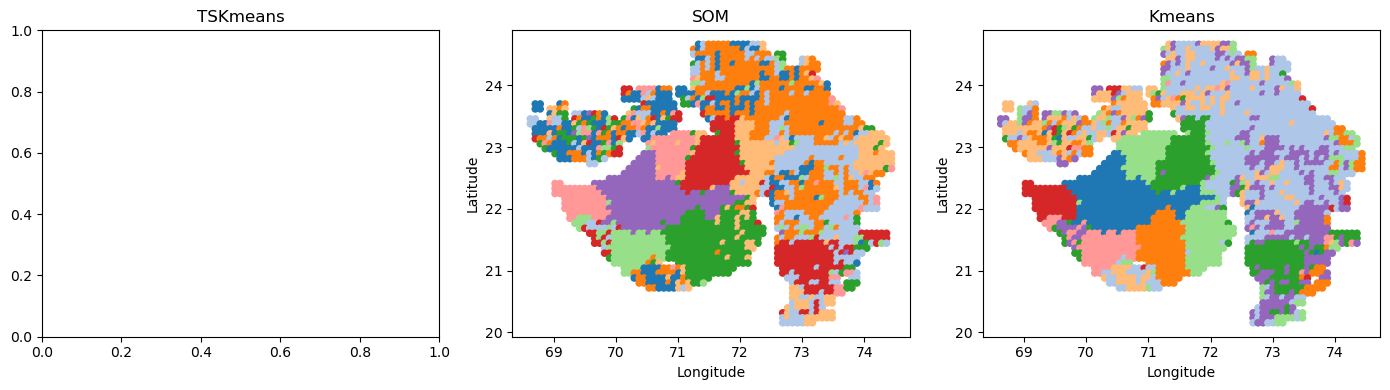

In [26]:
dfmean = df_bio_long.groupby(['Index','Latitude','Longitude'])['Bio'].mean().reset_index()
# dflabel_tskm = TSKMClassifier.get_df_label()
dflabel_som = som_classifier.get_df_label()
dflabel_km = km_classifier.get_df_label()

fig, axes = plt.subplots(ncols=3, figsize=(14,4))

n_colors = som_x*som_y
palette = sns.color_palette("tab20", n_colors=n_colors)
# plot = sns.scatterplot(data=pd.merge(dfmean,dflabel_tskm,on='Index'),x='Longitude',y='Latitude',hue='Label', palette=palette, s=30, linewidth=0, legend=False, ax=axes[0])
axes[0].set_title('TSKmeans')
plot = sns.scatterplot(data=pd.merge(dfmean,dflabel_som,on='Index'),x='Longitude',y='Latitude',hue='Label', palette=palette, s=30, linewidth=0, legend=False, ax=axes[1])
axes[1].set_title('SOM')
plot = sns.scatterplot(data=pd.merge(dfmean,dflabel_km,on='Index'),x='Longitude',y='Latitude',hue='Label', palette=palette, s=30, linewidth=0, legend=False, ax=axes[2])
axes[2].set_title('Kmeans')

plt.tight_layout()
plt.show()

In [27]:
df_stc = pd.merge(df_spatiotemporal, dflabel_km)

In [28]:
df_stc = pd.get_dummies(df_stc,columns=['Label'])

In [29]:
df_stce = pd.merge(df_stc, df_ext_annual, on='Year', how='left')

In [30]:
ext_features = list(df_ext_annual.drop('Year',axis=1).columns)

<Axes: >

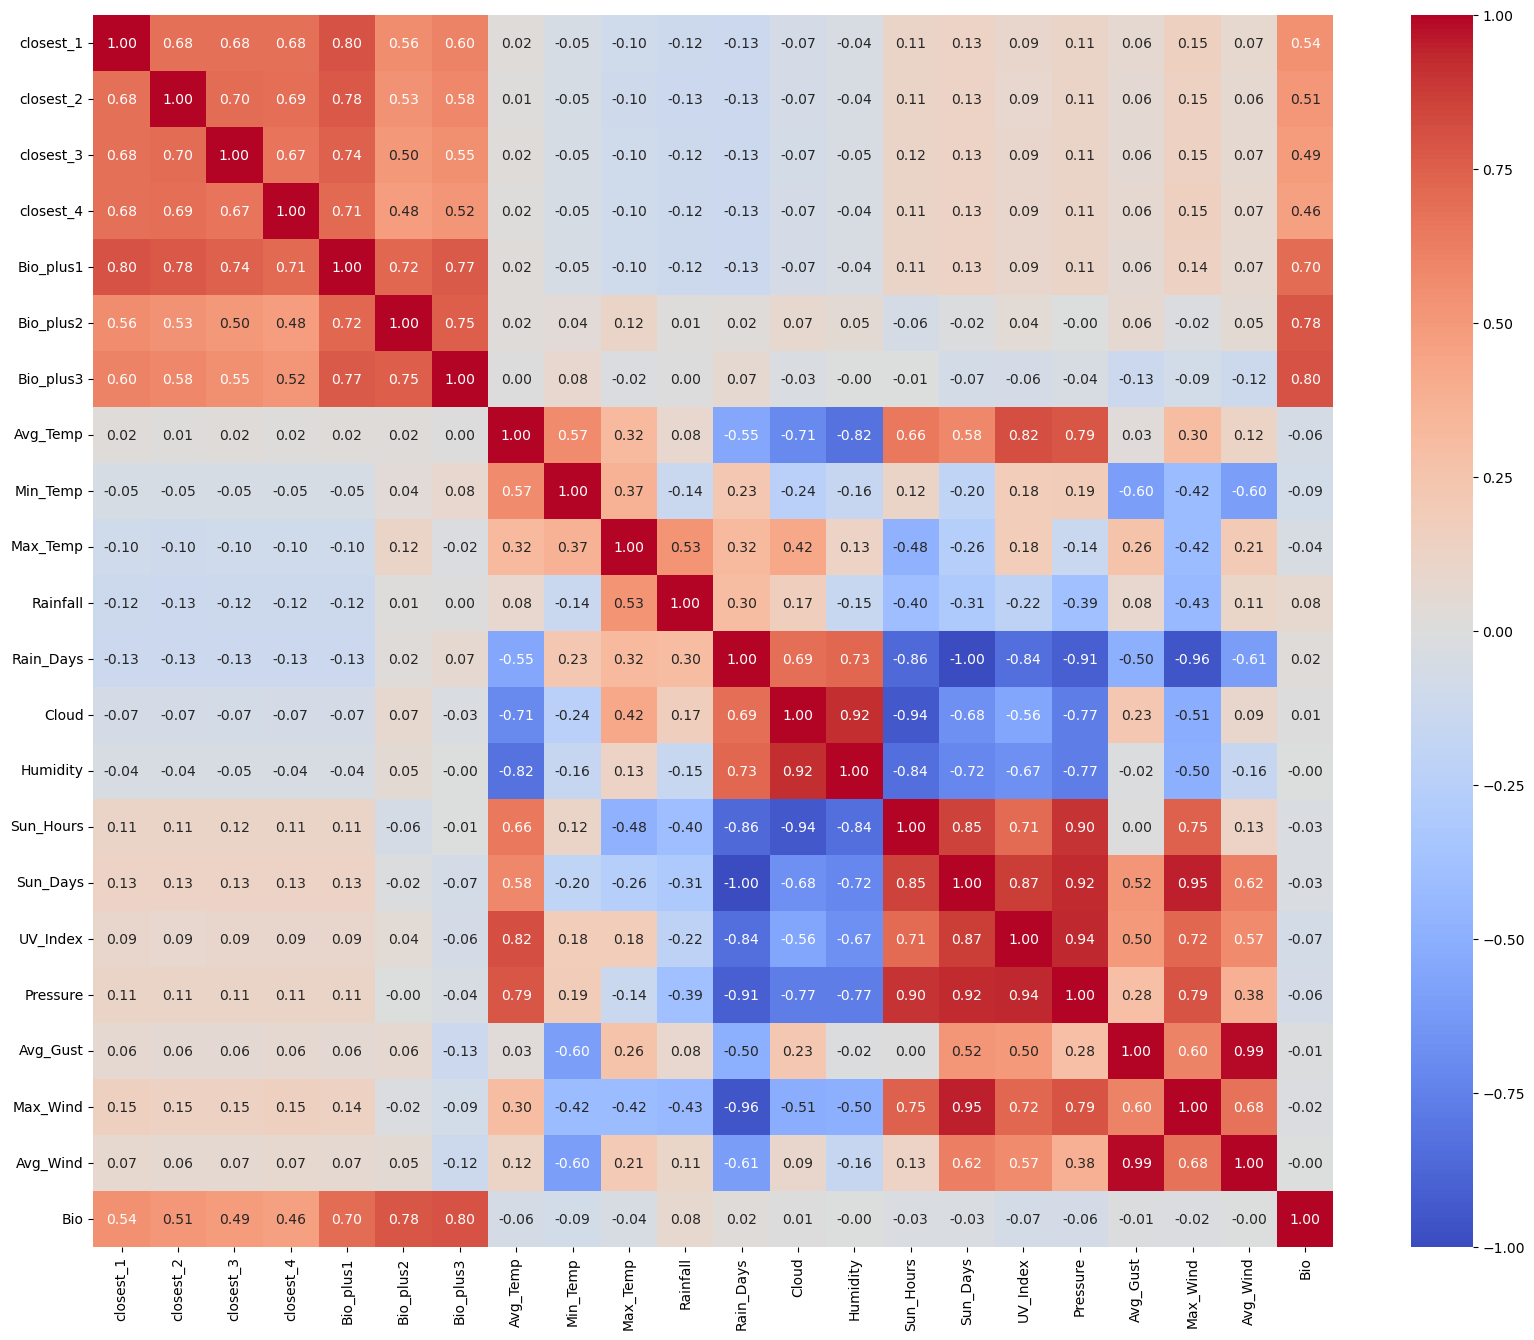

In [31]:
corr_value_stce = df_stce[spatial_features+temporal_features+ext_features+['Bio']].corr()

plt.figure(figsize=(20,16))
sns.heatmap(corr_value_stce, vmin=-1,vmax=1,cmap='coolwarm', annot=True, fmt='.2f')

## Forecast - Model

In [32]:
df_train = df_bio_long.copy()
df_2018 = df_bio_long.loc[df_bio_long['Year'] == 2010].drop(columns=['Bio'])
df_2018['Year'] = 2018
df_2019 = df_bio_long.loc[df_bio_long['Year'] == 2010].drop(columns=['Bio'])
df_2019['Year'] = 2019

In [33]:
def add_temporal(dftrain, df2018, df2019, past_count):
    past_count = 3
    for i in range(1,past_count+1):
        df_lag=df_bio_long.copy()[['Index','Year','Bio']]
        df_lag['Year'] = df_lag['Year']+i
        dftrain = dftrain.merge(df_lag, on=['Index', 'Year'], how='left',suffixes=('',f'_plus{i}'))
        df2018 = df2018.merge(df_lag, on=['Index', 'Year'], how='left',suffixes=('',f'_plus{i}'))
        df2019 = df2019.merge(df_lag, on=['Index', 'Year'], how='left',suffixes=('',f'_plus{i}'))
    
    df2018.rename(columns={'Bio': 'Bio_plus1'}, inplace=True)
    df2019.rename(columns={'Bio': 'Bio_plus1'}, inplace=True)
    return dftrain,df2018,df2019

def add_spatial(df_train, df_2018, df_2019, n_closest):
    dftrain, df2018, df2019 = df_train.copy(), df_2018.copy(), df_2019.copy()
    df_closest = pd.DataFrame(df_bio['Index'])
    df_closest['closest'] = df_bio['Index'].apply(lambda x: df_dist[str(x)].nsmallest(n_closest).index.tolist())

    for i in range(n_closest):
        dftrain['closest_'+str(i)] = dftrain.apply(lambda x:
                                                        np.nan if str(int(x['Year'])-1) not in years else
                                                        df_bio.loc[df_closest.loc[int(x['Index'])]['closest'][i],str(int(x['Year'])-1)],
                                                        axis=1)
        
        df2018['closest_'+str(i)] = df2018.apply(lambda x:
                                                        np.nan if str(int(x['Year'])-1) not in years else
                                                        df_bio.loc[df_closest.loc[int(x['Index'])]['closest'][i],str(int(x['Year'])-1)],
                                                        axis=1)
        
        df2019['closest_'+str(i)] = df2019.apply(lambda x:
                                                        np.nan if str(int(x['Year'])-1) not in years else
                                                        df_bio.loc[df_closest.loc[int(x['Index'])]['closest'][i],str(int(x['Year'])-1)],
                                                        axis=1)
    
    return dftrain, df2018, df2019

def add_label(dftrain, df2018, df2019, df_label, OHE=False): 
    dftrain = pd.merge(dftrain, df_label)
    df2018 = pd.merge(df2018, df_label)
    df2019 = pd.merge(df2019, df_label)
    if OHE :
        return pd.get_dummies(dftrain, columns=['Label']),pd.get_dummies(df2018, columns=['Label']),pd.get_dummies(df2019, columns=['Label'])
    else :
        return dftrain, df2018, df2019

def add_ext(dftrain, df2018, df2019, df_ext):
    return pd.merge(dftrain, df_ext, on='Year', how='left'),pd.merge(df2018, df_ext, on='Year', how='left'),pd.merge(df2019, df_ext, on='Year', how='left')

In [34]:
df_train_regres, df_2018_regres, df_2019_regres = add_ext(df_train, df_2018, df_2019, df_ext_annual)

In [35]:
df_st_train_whole, df_st_2018_whole, df_st_2019_whole = add_spatial(df_train, df_2018, df_2019, 5)
df_st_train_whole, df_st_2018_whole, df_st_2019_whole = add_temporal(df_st_train_whole, df_st_2018_whole, df_st_2019_whole, 3)
df_stc_train_whole, df_stc_2018_whole, df_stc_2019_whole = add_label(df_st_train_whole, df_st_2018_whole, df_st_2019_whole, dflabel_km, OHE=True)
df_ste_train_whole, df_ste_2018_whole, df_ste_2019_whole = add_ext(df_st_train_whole, df_st_2018_whole, df_st_2019_whole, df_ext_annual)
df_stce_train_whole, df_stce_2018_whole, df_stce_2019_whole = add_ext(df_stc_train_whole, df_stc_2018_whole, df_stc_2019_whole, df_ext_annual)

In [44]:
# Import machine learning frameworks
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import tensorflow as tf
import optuna

In [37]:
def create_pipeline(model, scaler):
    pipeline = Pipeline([
        ('scaler', scaler),  # Standardize the features
        ('model', model)  # Your chosen model
    ])
    return pipeline

def eval_whole(model, splits, dftrain):
    train_err = []
    valid_err = []

    X = dftrain.copy().drop(columns=['Index','closest_0'])
    y = X.pop('Bio')

    tscv = TimeSeriesSplit(n_splits=splits, test_size=2418)

    for train_index, valid_index in tscv.split(X):
        valid_year = X.iloc[valid_index]['Year'].unique()[0]
        # print(f"Testing on year : {valid_year}")

        x_train, y_train = X.iloc[train_index], y.iloc[train_index]
        x_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

        pipeline = create_pipeline(model, MinMaxScaler())

        pipeline.fit(x_train, y_train)

        train_pred = pipeline.predict(x_train)
        valid_pred = pipeline.predict(x_valid)

        train_score = mean_absolute_error(y_train, train_pred)
        valid_score = mean_absolute_error(y_valid, valid_pred)

        train_err.append(train_score)
        valid_err.append(valid_score)

        # print(f'Train Score {train_score:.5f}, Valid Score {valid_score:.5f}')

    print(f'Mean Train Score : {np.mean(train_err):.5f}, Mean Valid Score : {np.mean(valid_err):.5f}')

    return train_err, valid_err, pipeline

def eval_linear(model, dftrain):
    mae_list = []
    for i in dftrain['Index'].unique():
        X = dftrain[dftrain['Index']==i].copy().drop(['Index','Latitude','Longitude'],axis=1)
        y = X.pop('Bio')

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        pipeline = create_pipeline(model, MinMaxScaler())
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mae_list.append(mae)

    print(f"Mean Absolute Error (MAE): {np.mean(mae_list)}")
    return mae_list

In [38]:
error_dict = {}

In [39]:
df_st_train_whole.dropna(inplace=True)
df_stc_train_whole.dropna(inplace=True)
df_ste_train_whole.dropna(inplace=True)
df_stce_train_whole.dropna(inplace=True)

datasets = {
    # 'ST' : df_st_train_whole,
    # 'STC' : df_stc_train_whole,
    # 'STE' : df_ste_train_whole,
    'STCE' : df_stce_train_whole
}

models = {
    'RF' : RandomForestRegressor(random_state=seed, verbose=0),
    'LGBM' : LGBMRegressor(random_state=seed, verbosity=-1)
}

In [ ]:
for model in models.keys():
    for data in datasets.keys():
        print(f'Model {model}, Data {data}')
        t_err, v_err, train_model = eval_whole(models[model], 4, datasets[data])
        error_dict[model+'_'+data] = np.mean(v_err)

In [ ]:
models_linear = {
    'LinReg' : LinearRegression(),
    'Ridge' : Ridge(random_state=seed),
    'Enet' : ElasticNet(random_state=seed)
}

In [ ]:
for model in models_linear.keys() :
    print(f'Model {model}')
    err = eval_linear(models_linear[model], df_train_regres)
    error_dict[model] = np.mean(err)

stce = 71.54/68.88/63.53  
stc = 62.90/55.11/42.74  
ste = 66.18/67.20/61.39  
st = 60.79/49.56/42.56

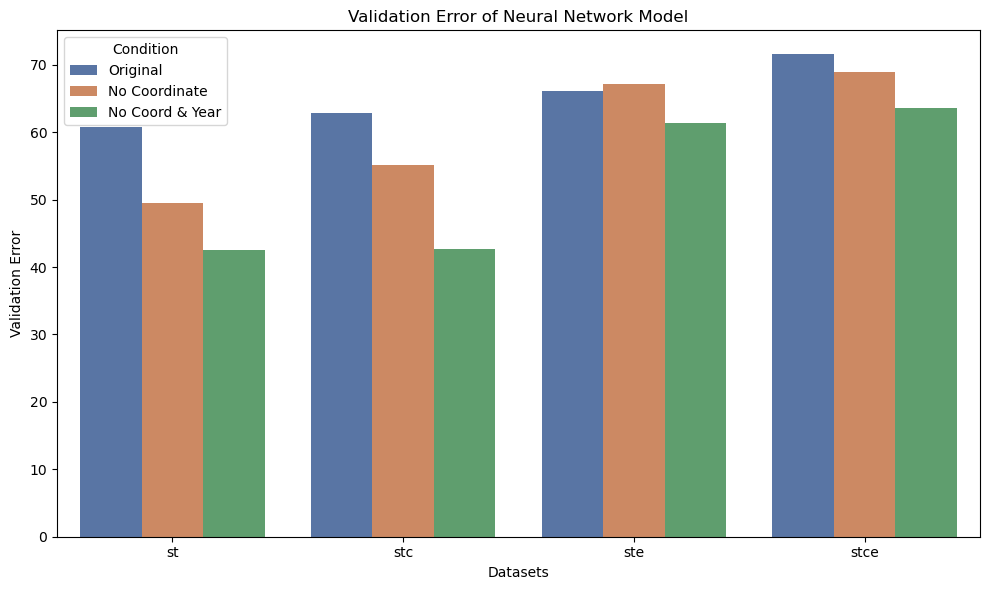

In [59]:
# Data
data = {
    'Dataset': ['st', 'stc', 'ste', 'stce'],
    'Original': [60.79, 62.90, 66.18, 71.54],
    'No Coordinate': [49.56, 55.11, 67.20, 68.88],
    'No Coord & Year': [42.56, 42.74, 61.39, 63.53]
}


# Convert data to long format for Seaborn
df = pd.DataFrame(data)
df_long = pd.melt(df, id_vars='Dataset', var_name='Condition', value_name='Validation Error')

# Plotting using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Dataset', y='Validation Error', hue='Condition', data=df_long, palette='deep')

# Customize plot
plt.xlabel('Datasets')
plt.ylabel('Validation Error')
plt.title('Validation Error of Neural Network Model')
plt.legend(title='Condition')

# Show plot
plt.tight_layout()
plt.show()

In [60]:
def lr_schedule(epoch):
    if epoch < 250:
        return 0.05
    elif epoch < 400:
        return 0.01
    elif epoch < 550:
        return 0.005
    elif epoch < 600:
        return 0.001
    else :
        return 0.0005
    
def eval_nn(model, dftrain):
    X = dftrain.copy().drop(['Index','closest_0','Latitude', 'Longitude'],axis=1)
    X_train = X[X['Year']<2017]
    y_train = X_train.pop('Bio')
    X_test = X[X['Year']==2017]
    y_test = X_test.pop('Bio')
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)
    
    _ = model.fit(X_train_scaled, y_train, epochs=1000, batch_size=512, callbacks=[early_stopping], validation_data=(X_test_scaled, y_test))

    loss = model.evaluate(X_test_scaled, y_test)
    print(f'Mean Absolute Error: {loss:.4f}')

    return loss,_

In [61]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(48, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  
        ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_absolute_error')

loss, history = eval_nn(model, df_st_train_whole)

Epoch 1/1000
19/19 [==============================] - 1s 11ms/step - loss: 141.3708 - val_loss: 158.9905
Epoch 2/1000
19/19 [==============================] - 0s 5ms/step - loss: 141.1289 - val_loss: 158.6651
Epoch 3/1000
19/19 [==============================] - 0s 5ms/step - loss: 140.6324 - val_loss: 157.9668
Epoch 4/1000
19/19 [==============================] - 0s 4ms/step - loss: 139.5604 - val_loss: 156.4784
Epoch 5/1000
19/19 [==============================] - 0s 4ms/step - loss: 137.3636 - val_loss: 153.6051
Epoch 6/1000
19/19 [==============================] - 0s 5ms/step - loss: 133.3472 - val_loss: 148.6431
Epoch 7/1000
19/19 [==============================] - 0s 5ms/step - loss: 126.8330 - val_loss: 141.0196
Epoch 8/1000
19/19 [==============================] - 0s 4ms/step - loss: 117.2149 - val_loss: 130.3861
Epoch 9/1000
19/19 [==============================] - 0s 4ms/step - loss: 104.9503 - val_loss: 117.2707
Epoch 10/1000
19/19 [==============================] - 0s 4ms/s

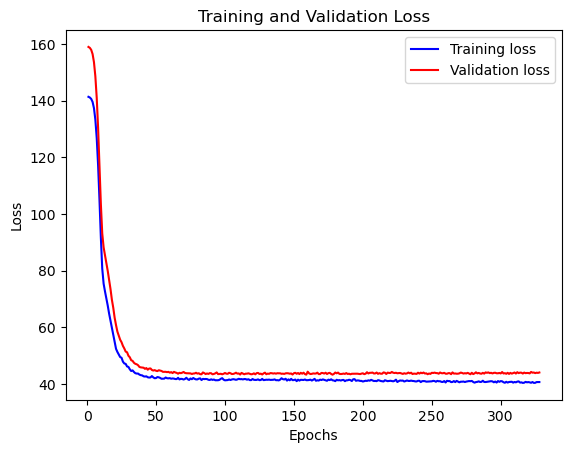

In [62]:
error_dict['ANN'] = loss

# Access the training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for x-axis
epochs = range(1, len(train_loss) + 1)

# Plotting
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plot
plt.show()

In [63]:
image_data = data_loader.dfbio

In [64]:
unet = get_model.Unet(image_data, images)

_, _, X_val_unet, y_val_unet = unet.prepare_data(fit=False)
model_unet = unet.get_model()
model_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae')

model_unet.load_weights('saved_models\\Unet_200_31.132_val.h5')

error_dict['Unet'] = model_unet.evaluate(X_val_unet, y_val_unet)

1/1 [==============================] - 0s 331ms/step - loss: 31.3855


In [65]:
lstm_3 = get_model.LSTM_3(image_data)

_, _, X_val_lstm, y_val_lstm = lstm_3.prepare_data(fit=False)
model_lstm = lstm_3.get_model()
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')

model_lstm.load_weights('saved_models\\LSTM_3_300_35.187_val.h5')

error_dict['LSTM'] = model_lstm.evaluate(X_val_lstm, y_val_lstm)

1/1 [==============================] - 0s 494ms/step - loss: 35.0586


In [66]:
clstm_3 = get_model.ConvLSTM_3(image_data, images)

_, _, X_val_clstm, y_val_clstm = clstm_3.prepare_data(fit=False)
model_clstm = clstm_3.get_model()
model_clstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae')

model_clstm.load_weights('saved_models\\ConvLSTM_M_300_26.04_val.h5')

error_dict['ConvLSTM'] = model_clstm.evaluate(X_val_clstm, y_val_clstm)

1/1 [==============================] - 1s 1s/step - loss: 25.3714


In [ ]:
rf_score = {x:error_dict[x] for x in error_dict.keys()if x.startswith('RF')}
lgbm_score = {x:error_dict[x] for x in error_dict.keys()if x.startswith('LGBM')}

data_list = []

for key in rf_score:
    data_list.append({'Dataset': key.split('_')[1], 'Model': 'rf', 'Score': rf_score[key]})

for key in lgbm_score:
    data_list.append({'Dataset': key.split('_')[1], 'Model': 'lgbm', 'Score': lgbm_score[key]})

df = pd.DataFrame(data_list)

data_list = []

for key in rf_score:
    data_list.append({'Dataset': key.split('_')[1], 'Model': 'rf', 'Score': rf_score[key]})

for key in lgbm_score:
    data_list.append({'Dataset': key.split('_')[1], 'Model': 'lgbm', 'Score': lgbm_score[key]})

df = pd.DataFrame(data_list)

sns.barplot(data=df.sort_values(by='Score',ascending=False),x='Dataset',y='Score',hue='Model', palette='deep')
plt.title('Model Comparison')
plt.ylabel('MAE')

plt.xticks(rotation=45)
plt.show()

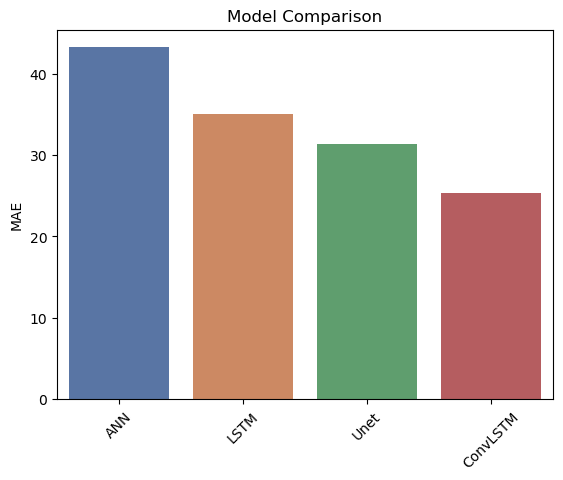

In [71]:
sorted_error_dict = dict(sorted(error_dict.items(), key=lambda item: item[1], reverse=True))

sns.barplot(x=list(sorted_error_dict.keys()), y=list(sorted_error_dict.values()), palette='deep')

plt.title('Model Comparison')
plt.ylabel('MAE')

plt.xticks(rotation=45)
plt.show()

In [67]:
def pred_nn(df_train, df_2018, df_2019, model):
    pred_dict = {'2018': [], '2019': []}  # Initialize a dictionary to store predictions

    X = df_train.drop(columns=['Index','closest_0','Latitude', 'Longitude'], axis=1)
    y = X.pop('Bio')

    # Apply the same scaling to both training and test data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)[:,1:]
    
    #lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)

    _ = model.fit(X_scaled, y, epochs=250, batch_size=512)

    X_2018 = df_2018.drop(['Index', 'closest_0','Latitude', 'Longitude'], axis=1)
    pred_2018 = model.predict(scaler.transform(X_2018)[:,1:])  # Scale test data as well
    pred_2018 = [0 if x < 0 else x for x in pred_2018[:,0]]

    df_2019['Bio_plus1'] = pred_2018
    for i in range(1, 5):
        col_name = 'closest_' + str(i)
        df_2019[col_name] = df_2019.apply(lambda x: pred_2018[df_closest['closest'][int(x['Index'])][i]], axis=1)

    X_2019 = df_2019.drop(['Index', 'closest_0','Latitude', 'Longitude'], axis=1)
    pred_2019 = model.predict(scaler.transform(X_2019)[:,1:])  # Scale test data as well
    pred_2019 = [0 if x < 0 else x for x in pred_2019[:,0]]

    pred_dict['2018'] = pred_2018
    pred_dict['2019'] = pred_2019

    return pred_dict


In [68]:
model_nn = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(48, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  
        ])

model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_absolute_error')

predictions = pred_nn(df_st_train_whole, df_st_2018_whole, df_st_2019_whole, model_nn)

Epoch 1/250
24/24 [==============================] - 1s 2ms/step - loss: 144.8646
Epoch 2/250
24/24 [==============================] - 0s 2ms/step - loss: 144.4215
Epoch 3/250
24/24 [==============================] - 0s 2ms/step - loss: 143.4669
Epoch 4/250
24/24 [==============================] - 0s 2ms/step - loss: 141.2961
Epoch 5/250
24/24 [==============================] - 0s 2ms/step - loss: 136.3705
Epoch 6/250
24/24 [==============================] - 0s 2ms/step - loss: 126.6844
Epoch 7/250
24/24 [==============================] - 0s 2ms/step - loss: 111.5188
Epoch 8/250
24/24 [==============================] - 0s 2ms/step - loss: 92.9852
Epoch 9/250
24/24 [==============================] - 0s 2ms/step - loss: 79.5295
Epoch 10/250
24/24 [==============================] - 0s 2ms/step - loss: 74.4537
Epoch 11/250
24/24 [==============================] - 0s 3ms/step - loss: 70.8709
Epoch 12/250
24/24 [==============================] - 0s 3ms/step - loss: 66.9827
Epoch 13/250
24/24

<Axes: ylabel='Count'>

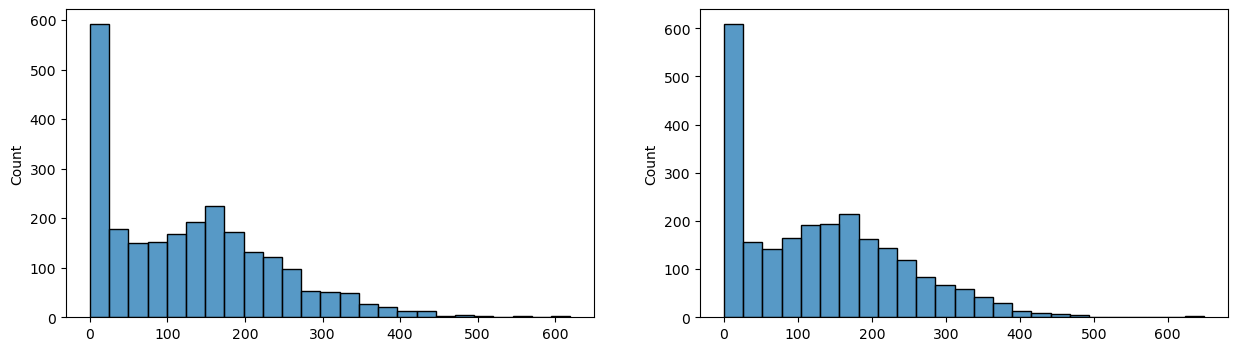

In [69]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
sns.histplot(predictions['2018'],ax=axes[0])
sns.histplot(predictions['2019'],ax=axes[1])

In [70]:
def pred_whole(df_train, df_2018, df_2019, model):
    pred_dict = {'2018': [], '2019': []}  # Initialize a dictionary to store predictions
    pipeline = create_pipeline(model, MinMaxScaler())

    X = df_train.drop(columns=['Index','closest_0'])
    y = X.pop('Bio')

    _ = pipeline.fit(X,y)

    X_2018 = df_2018.drop(['Index','closest_0'],axis=1)

    pred_2018 = pipeline.predict(X_2018)

    X_2019 = df_2019.copy()
    X_2019['Bio_plus1'] = pred_2018
    for i in range(1,5):
        X_2019['closest_'+str(i)] = X_2019.apply(lambda x: pred_2018[df_closest['closest'][int(x['Index'])][i]],axis=1)

    
    X_2019 = X_2019.drop(['Index','closest_0'],axis=1)
    pred_2019 = pipeline.predict(X_2019)

    pred_dict['2018'] = pred_2018
    pred_dict['2019'] = pred_2019

    return pred_dict


In [ ]:
model = RandomForestRegressor(random_state=seed, verbose=0)
predictions = pred_whole(df_stce_train_whole, df_stce_2018_whole, df_stce_2019_whole, model)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))

model = ElasticNet()
pipeline = create_pipeline(model, StandardScaler())

i = 5

X = df_train_regres[df_train_regres['Index']==i].drop(['Index','Latitude','Longitude'],axis=1)
y = X.pop('Bio')

X_2018 = df_2018_regres[df_2018_regres['Index']==i].drop(['Index','Latitude','Longitude'],axis=1)
X_2019 = df_2019_regres[df_2019_regres['Index']==i].drop(['Index','Latitude','Longitude'],axis=1)

_ = pipeline.fit(X,y)
pred_2018 = pipeline.predict(X_2018)
pred_2019 = pipeline.predict(X_2019)

df_train_regres[df_train_regres['Index']==i]['Bio'].reset_index(drop=True).plot(ax=axes[0])
axes[0].set_ylabel('Bio')
axes[0].set_xlabel('Index')
axes[0].set_title('Train Data')

bio_list = df_train_regres[df_train_regres['Index']==i]['Bio'].tolist()
bio_list.append(int(pred_2018))
bio_list.append(int(pred_2019))
pd.Series(bio_list).plot(ax=axes[1])
axes[1].set_ylabel('Bio')
axes[1].set_xlabel('Index')
axes[1].set_title('Train vs. Prediction')

# Add regression line on the second plot
sns.regplot(x=list(range(len(bio_list))), y=bio_list, ax=axes[1], color='red')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
def pred_linear(df_train, df_2018, df_2019, model):
    pred_dict = {'2018': [], '2019': []}  # Initialize a dictionary to store predictions

    # Loop through unique 'Index' values in df_train
    for i in df_train['Index'].unique():
        # Extract features and target for training
        X = df_train[df_train['Index'] == i].drop(['Index','Latitude','Longitude'],axis=1)
        y = X.pop('Bio')

        # Extract features for testing in 2018 and 2019
        X_2018 = df_2018[df_2018['Index'] == i].drop(['Index','Latitude','Longitude'],axis=1)
        X_2019 = df_2019[df_2019['Index'] == i].drop(['Index','Latitude','Longitude'],axis=1)

        # Create and fit the pipeline
        pipeline = create_pipeline(model, MinMaxScaler())
        _ = pipeline.fit(X, y)

        # Make predictions for 2018 and 2019
        pred_2018 = pipeline.predict(X_2018)
        pred_2019 = pipeline.predict(X_2019)

        # Append predictions to the dictionary
        pred_dict['2018'].append(int(pred_2018))
        pred_dict['2019'].append(int(pred_2019))

    return pred_dict


In [ ]:
model = ElasticNet()
predictions = pred_linear(df_train_regres, df_2018_regres, df_2019_regres, model)

1/1 [==============================] - 0s 236ms/step


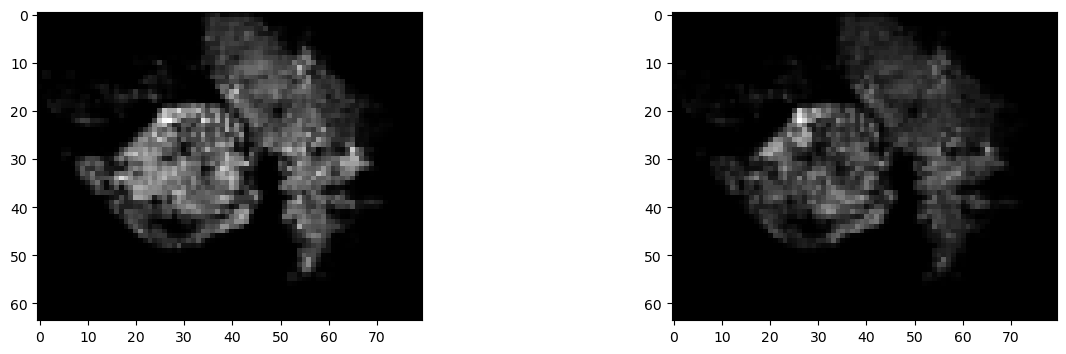

In [72]:
model_clstm.load_weights('saved_models\\ConvLSTM_M_300_26.04.h5')
clstm_3.model = model_clstm
preds_image, predictions = clstm_3.predict(selected_pix)

fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].imshow(preds_image[0][0,:,:,0], cmap='gray')
axes[1].imshow(preds_image[1][0,:,:,0], cmap='gray')

In [73]:
df_2018['2018'] = [int(x) for x in predictions['2018']]
df_2019['2019'] = [int(x) for x in predictions['2019']]

In [74]:
print(df_2018['2018'].sum(), df_2018['2018'].sum()*0.8, df_2018['2018'].mean())
print(df_2019['2019'].sum(), df_2019['2019'].sum()*0.8, df_2019['2019'].mean())

321031 256824.80000000002 132.7671629445823
326667 261333.6 135.09801488833747


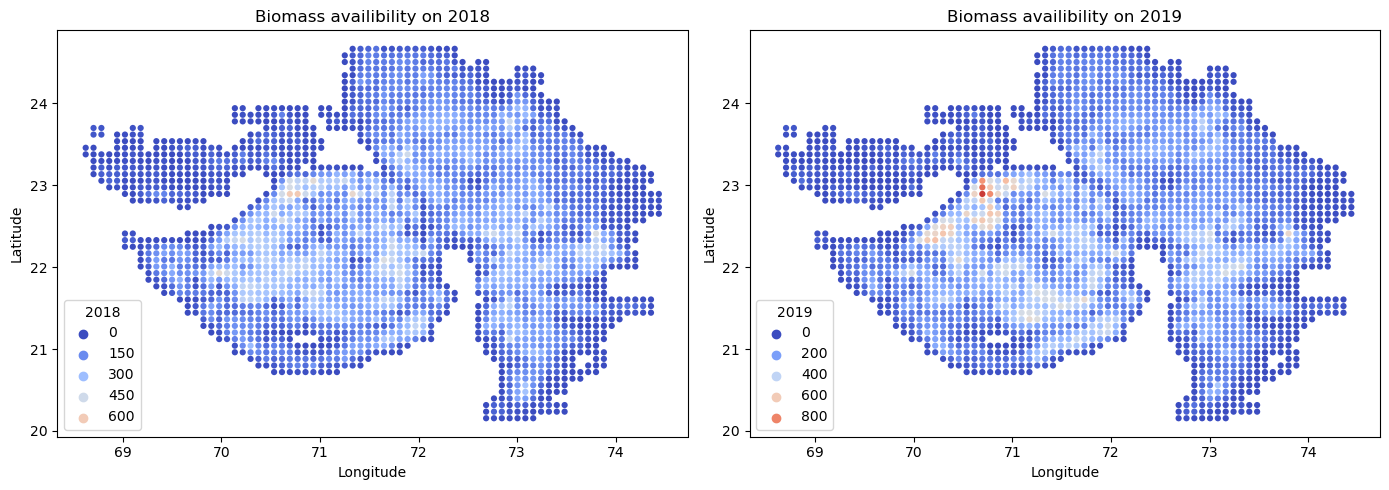

In [75]:
# Prediction results on year 2018 and year 2019
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.scatterplot(data=df_2018,x='Longitude',y='Latitude',hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
axes[0].set_title('Biomass availibility on 2018')
sns.scatterplot(data=df_2019,x='Longitude',y='Latitude',hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
axes[1].set_title('Biomass availibility on 2019')

plt.tight_layout()
plt.show()

In [76]:
def real_eval(df_real, predictions):
    mae_2018 = mean_absolute_error(df_real['2018'], predictions['2018'])
    mae_2019 = mean_absolute_error(df_real['2019'], predictions['2019'])
    return mae_2018,mae_2019

In [77]:
real_eval(df_real, predictions)

(33.83602106166651, 49.93557167704602)

In [78]:
dfpred_2018 = df_2018[['Index','Latitude','Longitude','2018']]
dfpred_2019 = df_2019[['Index','Latitude','Longitude','2019']]
dfcluster = dfpred_2018.merge(dfpred_2019, on =['Index','Latitude','Longitude'])

dfcluster.head(5)

Index  Latitude  Longitude  2018  2019
0      0  24.66818   71.33144     7     6
1      1  24.66818   71.41106    42    32
2      2  24.66818   71.49069    60    67
3      3  24.66818   71.57031    86    75
4      4  24.66818   71.64994    18    22

In [79]:
dfcluster.to_csv('./dataset/dfcluster_ConvLSTM_25.csv',index=False)

In [80]:
from pulp import *
from ortools.linear_solver import pywraplp

In [82]:
used_2018 = []
group_dict_2018 = {}
costs_2018 = []

used_2019 = [] 
group_dict_2019 = {}
costs_2019 = []

In [83]:
def calc_loss(loss) :
    C = loss['transport'][-1]*0.001
    U = loss['underutil'][-1]
    return C, U

def plot_loss(loss):
        
    plt.figure(figsize=(8, 6))

    sns.lineplot(np.array(loss['transport']) * 0.001, label='Transport Loss (scaled)')
    sns.lineplot(np.array(loss['underutil']), label='Underutilization Loss')
    sns.lineplot(np.array(loss['underutil']) + np.array(loss['transport']) * 0.001, label='Total Loss')

    plt.xlabel('Iteration')  # Replace 'X Label' with your actual x-axis label
    plt.ylabel('Costs')  # Replace 'Y Label' with your actual y-axis label

    plt.title('Greedy Method')
    plt.legend()
    plt.show()

def plot_map (dfcluster, used, group_dict) :
    # Plot used sites and depots
    fig, axes = plt.subplots(ncols=2, figsize=(14,5))
    sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used)],x='Longitude',y='Latitude',hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
    sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used)],x='Longitude',y='Latitude',hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
    sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[0])
    sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[1])
    sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[0])
    sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[1])
    axes[0].set_title('Config 2018')
    axes[1].set_title('Config 2019')
    plt.tight_layout()
    plt.show()

In [90]:
def assign_greedy(maxval_index, dfcluster, avail, used, cap):
    group_assign = []
    transport_loss = 0
    group_assign.append(maxval_index)
    distances = df_dist[str(maxval_index)].copy()/((avail['2018']+avail['2019'])/2)
    
    while True :
        distances.loc[used+group_assign] = np.nan
        closest = np.nanargmin(distances.tolist())
        dist = df_dist[str(closest)][maxval_index]

        current_biomass = (dfcluster[dfcluster['Index'].isin(group_assign)]['2018'].sum(), dfcluster[dfcluster['Index'].isin(group_assign)]['2019'].sum())
        add_biomass = (dfcluster[dfcluster['Index']==closest]['2018'].values[0], dfcluster[dfcluster['Index']==closest]['2019'].values[0])
        if (current_biomass[0] + add_biomass[0] > cap) or (current_biomass[1] + add_biomass[1] > cap) :
            break

        group_assign.append(closest)
        transport_loss += dist*add_biomass[0] + dist*add_biomass[1]

    underutil_loss = (2*cap - current_biomass[0] - current_biomass[1])

    return group_assign, transport_loss, underutil_loss

def stage1(dfcluster, cap) :
    losses = {'transport':[],'underutil':[]}
    C_current, U_current = 0,0
    group_dict = {}
    used_2018, used_2019 = []
    annual_collected = (0,0)
    annual_threshold = (dfcluster['2018'].sum()*0.8, dfcluster['2019'].sum()*0.8)

    while (annual_collected[0]<annual_threshold[0]) or (annual_collected[1]<annual_threshold[1]) :
        avail = dfcluster[~dfcluster['Index'].isin(used_2018) and ~dfcluster['Index'].isin(used_2019)]
        maxval_index = ((avail['2018']+avail['2019'])/2).idxmax()

        group_assign, C, U = assign_greedy(maxval_index=maxval_index, dfcluster=dfcluster, avail=avail, used=used, cap=cap)

        used += group_assign
        group_dict[maxval_index] =  group_assign

        C_current += C
        U_current += U

        losses['transport'].append(C_current)
        losses['underutil'].append(U_current)

        annual_collected = (dfcluster[dfcluster['Index'].isin(used)]['2018'].sum(), dfcluster[dfcluster['Index'].isin(used)]['2019'].sum())
        print(f'Total biomass : {annual_collected}')
    
    return used, group_dict, losses

In [101]:
losses = {'transport':[],'underutil':[]}
C_current, U_current = 0,0
group_dict = {}
used_2018, used_2019 = [], []
annual_collected = (0,0)
annual_threshold = (dfcluster['2018'].sum()*0.8, dfcluster['2019'].sum()*0.8)

In [104]:
avail = dfcluster[~dfcluster['Index'].isin(used_2018) & ~dfcluster['Index'].isin(used_2019)]
maxval_index = ((avail['2018']+avail['2019'])/2).idxmax()

In [ ]:
group_assign_2018, group_assign_2019 = [maxval_index], [maxval_index]
distances = df_dist[str(maxval_index)].copy()/((avail['2018']+avail['2019'])/2)

In [109]:
distances

0         40.755815
1          7.099057
2          4.262595
3          3.485793
4         14.060290
           ...     
2413      98.720000
2414    1169.129800
2415            inf
2416     236.854360
2417     600.352100
Length: 2418, dtype: float64

In [86]:
used_greed, group_dict_greed, loss_greed = stage1(dfcluster, cap=20000)

Total biomass : (13719, 19735)
Total biomass : (31750, 39626)
Total biomass : (51735, 59245)
Total biomass : (68079, 79010)
Total biomass : (87657, 98688)
Total biomass : (107502, 117819)
Total biomass : (123367, 137482)
Total biomass : (142875, 157372)
Total biomass : (162755, 174131)
Total biomass : (181640, 193898)
Total biomass : (201510, 213598)
Total biomass : (221366, 230692)
Total biomass : (239990, 250661)
Total biomass : (259903, 269455)


In [87]:
calc_loss(loss_greed)

(34939.554883, 30642)

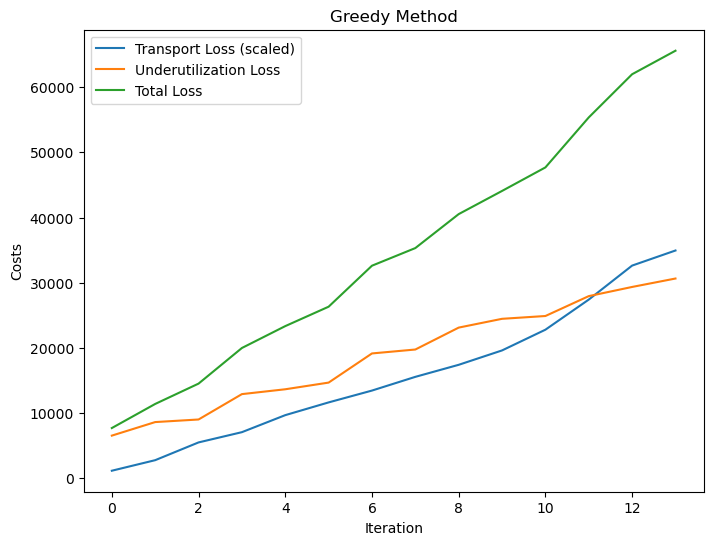

In [88]:
plot_loss(loss_greed)

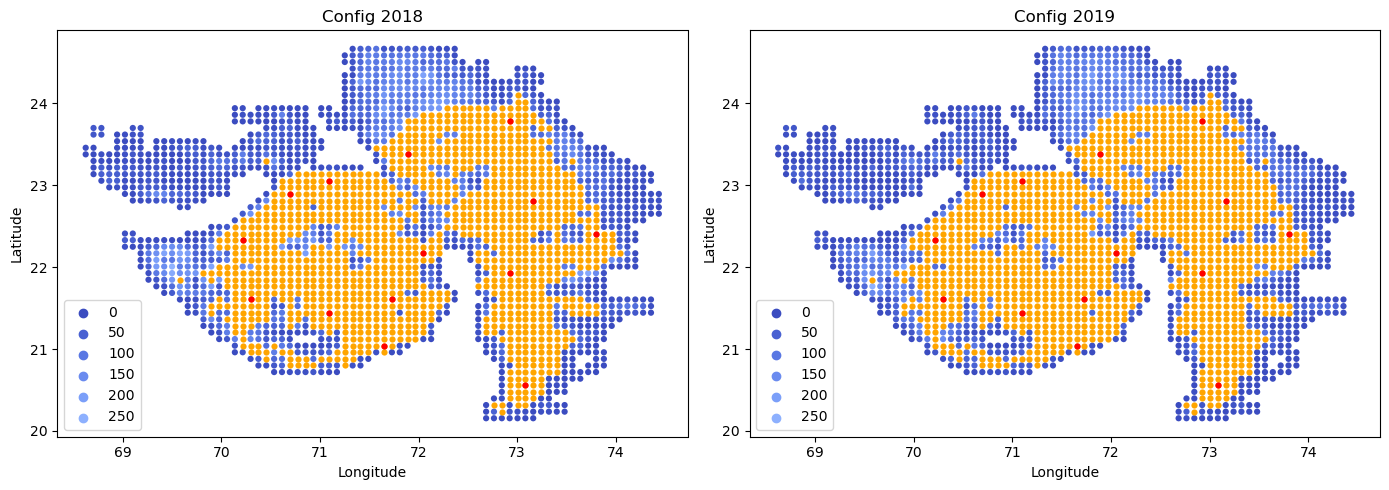

In [89]:
plot_map(dfcluster, used_greed, group_dict_greed)

In [ ]:
class MILP_Single():
    def __init__(self, dfcluster, year, iter, cap=20000):
        self.used = []
        self.group_dict = {}
        self.costs = []
        self.iter=iter
        self.cap = cap
        self.year = year

        self.avail = dfcluster[~dfcluster['Index'].isin(self.used)]
        self.sites = self.avail['Index'].tolist()
        self.depots = self.avail[str(year)].nlargest(iter).index.tolist()
    
    def update(self, used):
        self.avail = dfcluster[~dfcluster['Index'].isin(used)]
        self.sites = self.avail['Index'].tolist()
        self.depots = self.avail[str(self.year)].nlargest(self.iter).index.tolist()

    def init_solver(self):
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not self.solver:
            raise Exception("Solver initialization failed")
        
        return solver
    
    def init_optvar(self):
        self.use_depot = {}
        self.assign_depot = {}

        for j in self.depots:
            self.use_depot[j] = self.solver.BoolVar(f"Use Depot {j}")

        for i in self.sites:
            for j in self.depots:
                self.assign_depot[(i, j)] = self.solver.BoolVar(f"Assign Depot {i},{j}")

    def run(self):
        solver = self.init_solver()

In [ ]:
for iter_index in tqdm(range(15), desc='Optimize'):
    avail = dfcluster[~dfcluster['Index'].isin(used_2018)]
    max_iter = 5
    maxval_index = avail['2018'].nlargest(max_iter).index.tolist()
    Sites = avail['Index'].tolist()
    Depots = maxval_index
    Biomass = avail.copy()['2018']
    cap = 20000

    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        raise Exception("Solver initialization failed")

    use_depot = {}
    assign_depot = {}

    for j in Depots:
        use_depot[j] = solver.BoolVar(f"Use Depot {j}")

    for i in Sites:
        for j in Depots:
            assign_depot[(i, j)] = solver.BoolVar(f"Assign Depot {i},{j}")

    trans_cost = solver.Sum(
        dfdist[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
        for i in Sites for j in Depots
    )

    under_cost = solver.Sum(
        cap * use_depot[j] - solver.Sum(
            Biomass[i] * assign_depot[i, j] for i in Sites
        ) for j in Depots
    )

    # Combine transportation cost and fixed cost for the total cost
    total_cost = trans_cost*0.001 + under_cost
    solver.Minimize(total_cost)

    solver.Add(solver.Sum(use_depot[j] for j in Depots) == 1)

    for i in Sites:
        for j in Depots:
            solver.Add(assign_depot[i, j] <= use_depot[j])

    for j in Depots:
        solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - cap * use_depot[j] <= 0)
        solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - 0.9 * cap * use_depot[j] >= 0)

    for i in Sites:
        solver.Add(solver.Sum(assign_depot[i, j] for j in Depots) <= 1)

    status = solver.Solve()

    losses = (total_cost.solution_value(), trans_cost.solution_value(), under_cost.solution_value())
    costs_2018.append(losses)

    variable_values = {
        var.name(): var.solution_value() for var in [use_depot[j] for j in Depots] +
        [assign_depot[i, j] for i in Sites for j in Depots]
    }

    group_assign_dict = {}
    centers = []
    for var_name, var_value in variable_values.items():
        if var_value > 0 :
            line = var_name
            if line.startswith('Assign Depot'):
                key = int(line.split(',')[1])
                value = int(line.split(',')[0].split(' ')[2])
                if key in group_assign_dict:
                    group_assign_dict[key].append(value)
                else:
                    group_assign_dict[key] = [value]
            else :
                centers.append(int(line.split(' ')[2]))

    for value_list in group_assign_dict.values():
        used_2018.extend(value_list)

    group_dict_2018.update(group_assign_dict)
    print(centers, losses)

In [ ]:
for iter_index in tqdm(range(3), desc='opt_2019') :
    print(f'Iter no: {iter_index+1}')
    Depots = list(group_dict_2018.keys())[5*iter_index:5*(iter_index+1)]
    Sites = dfcluster[~dfcluster['Index'].isin(used_2019 + list(group_dict_2018.keys())[5*(iter_index+1):])]['Index'].tolist()
    Biomass = dfcluster.copy()['2019']
    cap = 20000

    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        raise Exception("Solver initialization failed")

    assign_depot = {}

    for i in Sites:
        for j in Depots:
            assign_depot[(i, j)] = solver.BoolVar(f"Assign Depot {i},{j}")

    trans_cost = solver.Sum(
        dfdist[str(j)][int(i)] * Biomass[i] * assign_depot[i, j]
        for i in Sites for j in Depots
    )

    under_cost = solver.Sum(
        cap - solver.Sum(
            Biomass[i] * assign_depot[i, j] for i in Sites
        ) for j in Depots
    )

    # Combine transportation cost and fixed cost for the total cost
    total_cost = trans_cost*0.001 + under_cost
    solver.Minimize(total_cost)

    for j in Depots:
        solver.Add(solver.Sum(Biomass[i] * assign_depot[i, j] for i in Sites) - cap <= 0)
        solver.Add(assign_depot[j, j] == 1)

    for i in Sites:
        solver.Add(solver.Sum(assign_depot[i, j] for j in Depots) <= 1)

    status = solver.Solve()
    print(total_cost.solution_value())

    losses = (total_cost.solution_value(), trans_cost.solution_value(), under_cost.solution_value())
    costs_2019.append(losses)

    variable_values = {
        var.name(): var.solution_value() for var in 
        [assign_depot[i, j] for i in Sites for j in Depots]
    }

    group_assign_dict = {}
    centers = []
    for var_name, var_value in variable_values.items():
        if var_value > 0 :
            line = var_name
            if line.startswith('Assign Depot'):
                key = int(line.split(',')[1])
                value = int(line.split(',')[0].split(' ')[2])
                if key in group_assign_dict:
                    group_assign_dict[key].append(value)
                else:
                    group_assign_dict[key] = [value]
            else :
                centers.append(int(line.split(' ')[2]))

    for value_list in group_assign_dict.values():
        used_2019.extend(value_list)

    group_dict_2019.update(group_assign_dict)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used_2018)],x='Longitude',y='Latitude',hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used_2019)],x='Longitude',y='Latitude',hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used_2018)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used_2019)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict_2018.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict_2019.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[1])
axes[0].set_title('Config 2018')
axes[1].set_title('Config 2019')
plt.tight_layout()
plt.show()

In [ ]:
total_cost = 0
transport_cost = 0
underutil_cost = 0
for costs_ in [costs_2018, costs_2019] :
    for cost in costs_:
        total_cost += cost[0]
        transport_cost += cost[1]
        underutil_cost += cost[2]

print(f'Total cost : {total_cost}')
print(f'Total transport : {transport_cost*0.001}')
print(f'Total underutil : {underutil_cost}')

In [ ]:
biomass_dict_2018 = {}
for keys in group_dict_2018.keys() :
    biomass_collected = 0
    for site in group_dict_2018[keys]:
        biomass_collected += dfcluster.loc[dfcluster['Index']==site]['2018'].values[0]
    biomass_dict_2018[keys] = biomass_collected
    
biomass_dict_2019 = {}
for keys in group_dict_2019.keys() :
    biomass_collected = 0
    for site in group_dict_2019[keys]:
        biomass_collected += dfcluster.loc[dfcluster['Index']==site]['2019'].values[0]
    biomass_dict_2019[keys] = biomass_collected

In [ ]:
dfdepot = pd.DataFrame(biomass_dict_2018.items(), columns=['depot_index','2018'])
dfdepot['2019'] = biomass_dict_2019.values()

In [ ]:
dfdepot = pd.DataFrame(group_dict_greed).T[['transport','biomass']].reset_index().rename(columns={'index':'depot_index'})
dfdepot['2018'] = dfdepot['biomass'].apply(lambda row: row[0])
dfdepot['2019'] = dfdepot['biomass'].apply(lambda row: row[1])
dfdepot.drop(columns=['biomass','transport'],inplace=True)

In [ ]:
dfdepot['2019'].sum()

In [ ]:
Depot = dfdepot['depot_index'].tolist()
Refinery = dfcluster['Index'].tolist()
Years = ['2018','2019']
Pellets = dfdepot.set_index('depot_index').to_dict()
Cap = 100000

solver = pywraplp.Solver.CreateSolver('SCIP')

# Create use_refinery variables
use_refinery = {}
for k in Refinery:
    use_refinery[k] = solver.BoolVar(f"Use Refinery {k}")

# Create assign_refinery variables
assign_refinery = {}
for j in Depot:
    for k in Refinery:
        for y in Years:
            assign_refinery[(j, k, y)] = solver.BoolVar(f"Assign Refinery ({j}, {k}, {y})")

# Define transport cost
trans_cost = sum(sum(dfdist[str(k)][int(j)] * (Pellets[y][j]) * assign_refinery[(j, k, y)] for j in Depot for k in Refinery) for y in Years)

# Define underutilization cost
under_cost = sum(sum(Cap*use_refinery[k]-sum((Pellets[y][j])*assign_refinery[j,k,y] for j in Depot) for k in Refinery) for y in Years)

# Overall cost
objective = trans_cost * 0.001 + under_cost
solver.Minimize(objective)

# Constraints
for y in Years :
    for k in Refinery :
        assignment_sum = sum(assign_refinery[j,k,y] for y in Years)
        solver.Add(assignment_sum == len(Years) * assign_refinery[(j, k, Years[0])])
        solver.Add(sum(Pellets[y][j]*assign_refinery[j,k,y] for j in Depot) - Cap*use_refinery[k] <= 0)

for y in Years :
    for j in Depot :
        solver.Add(sum(assign_refinery[j,k,y] for k in Refinery) == 1)

for y in Years :
    for j in Depot :
        for k in Refinery :
            solver.Add(assign_refinery[j,k,y] <= use_refinery[k])

solver.Add(sum(use_refinery.values()) >= 3)
solver.Add(sum(use_refinery.values()) <= 5)

status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print("Solution status: Optimal")
else:
    print("Solution status: Not optimal")

print("Total costs:", solver.Objective().Value())

assign ={}
use = []
for k in Refinery:
    if (use_refinery[k].solution_value()>0):
        use.append(k)
        
    for j in Depot:
        if (assign_refinery[(j, k, '2018')].solution_value()>0):
            if k in assign:
                assign[k].append(j)
            else :
                assign[k] = [j]

for i in use:
    if i not in used_2018:
        used_2018.append(i)
    if i not in used_2019:
        used_2019.append(i)

In [ ]:
underutil_cost

In [ ]:
under_cost.solution_value()

In [ ]:
# Calculate the total costs
transport_cost = C_greed
underutil_cost = U_greed
total_transport = transport_cost + trans_cost.solution_value()
total_under = underutil_cost + under_cost.solution_value()
total_forecast = (dfreal['2018']-predictions['2018']).abs().sum() + (dfreal['2019']-predictions['2019']).abs().sum()
total_cost = 0.001*total_transport + total_under + total_forecast

score = 100 - (80*total_cost)/500000
score

In [ ]:
total_cost

In [ ]:
total_transport, total_under, total_forecast

In [ ]:
# Plot the whole configuration network
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used_greed)],x='Longitude',y='Latitude',hue='2018', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[~dfcluster['Index'].isin(used_greed)],x='Longitude',y='Latitude',hue='2019', palette='coolwarm', hue_norm=(0,1000), s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used_greed)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(used_greed)], x='Longitude', y='Latitude', color='orange', s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict_greed.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(list(group_dict_greed.keys()))], x='Longitude', y='Latitude', color='red', s=20, linewidth=0, ax=axes[1])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(use)], x='Longitude', y='Latitude', color='black', s=20, linewidth=0, ax=axes[0])
sns.scatterplot(data=dfcluster[dfcluster['Index'].isin(use)], x='Longitude', y='Latitude', color='black', s=20, linewidth=0, ax=axes[1])
axes[0].set_title('Config 2018')
axes[1].set_title('Config 2019')
plt.tight_layout()
plt.show()

In [ ]:
# Create submission dataframe
submission = pd.DataFrame(columns=['year', 'data_type', 'source_index', 'destination_index', 'value'])
submission

In [ ]:
depot_rows = {
    'year': '20182019',
    'data_type': 'depot_location',
    'source_index': list(group_dict_2018.keys()),
    'destination_index': None,  # Empty destination_index
    'value': None  # Empty value
}
refinery_rows = {
    'year': '20182019',
    'data_type': 'refinery_location',
    'source_index': use,
    'destination_index': None,  # Empty destination_index
    'value': None  # Empty value
}

submission = pd.concat([submission,pd.DataFrame(depot_rows),pd.DataFrame(refinery_rows)],ignore_index=True)

forecast_2018 = {
    'year': '2018',
    'data_type' : 'biomass_forecast',
    'source_index' : dfcluster['Index'],
    'destination_index': None,
    'value': df_2018['2018']
}
forecast_2019 = {
    'year': '2019',
    'data_type' : 'biomass_forecast',
    'source_index' : dfcluster['Index'],
    'destination_index': None,
    'value': df_2019['2019']
}

submission = pd.concat([submission,pd.DataFrame(forecast_2018),pd.DataFrame(forecast_2019)],ignore_index=True)

biomass_demand_18 = pd.DataFrame(group_dict_2018.items(),columns=['depot_loc','site_loc']).explode('site_loc')
biomass_demand_19 = pd.DataFrame(group_dict_2019.items(),columns=['depot_loc','site_loc']).explode('site_loc')

biomass_demand_2018 = {
    'year': '2018',
    'data_type' : 'biomass_demand_supply',
    'source_index' : biomass_demand_18['site_loc'],
    'destination_index': biomass_demand_18['depot_loc']
}
biomass_demand_2019 = {
    'year': '2019',
    'data_type' : 'biomass_demand_supply',
    'source_index' : biomass_demand_19['site_loc'],
    'destination_index': biomass_demand_19['depot_loc']
}

biomass_demand_2018 = pd.DataFrame(biomass_demand_2018).merge(df_2018[['Index','2018']], left_on='source_index', right_on='Index', how='left')
biomass_demand_2019 = pd.DataFrame(biomass_demand_2019).merge(df_2019[['Index','2019']], left_on='source_index', right_on='Index', how='left')

biomass_demand_2018 = biomass_demand_2018.drop(columns=['Index']).rename(columns={'2018':'value'})
biomass_demand_2019 = biomass_demand_2019.drop(columns=['Index']).rename(columns={'2019':'value'})

submission = pd.concat([submission,biomass_demand_2018,biomass_demand_2019],ignore_index=True)

dftemp = pd.DataFrame(list(assign.items()), columns=['source_index', 'destination_index']).explode('destination_index')

pellet_demand = pd.DataFrame()
pellet_demand['source_index'], pellet_demand['destination_index'] = dftemp['destination_index'], dftemp['source_index']

pellet_demand_2018 = {
    'year': '2018',
    'data_type' : 'pellet_demand_supply',
    'source_index' : pellet_demand['source_index'].astype(int),
    'destination_index': pellet_demand['destination_index'].astype(int)
}
pellet_demand_2019 = {
    'year': '2019',
    'data_type' : 'pellet_demand_supply',
    'source_index' : pellet_demand['source_index'].astype(int),
    'destination_index': pellet_demand['destination_index'].astype(int)
}

pellet_demand_2018 = pd.DataFrame(pellet_demand_2018).merge(dfdepot[['depot_index','2018']], how='left', left_on='source_index', right_on='depot_index')
pellet_demand_2019 = pd.DataFrame(pellet_demand_2019).merge(dfdepot[['depot_index','2019']], how='left', left_on='source_index', right_on='depot_index')

pellet_demand_2018 = pellet_demand_2018.drop(columns=['depot_index']).rename(columns={'2018':'value'})
pellet_demand_2019 = pellet_demand_2019.drop(columns=['depot_index']).rename(columns={'2019':'value'})

submission = pd.concat([submission,pellet_demand_2018,pellet_demand_2019],ignore_index=True)

In [ ]:
submission.to_csv('test_submit.csv')

In [ ]:
# Check constraint number 8
x = submission[submission['data_type']=='pellet_demand_supply'].groupby(by=['year','source_index'])['value'].sum().reset_index()
y = submission[submission['data_type']=='biomass_demand_supply'].groupby(by=['year','destination_index'])['value'].sum().reset_index()

merged = pd.merge(y, x, left_on=['year', 'destination_index'], right_on=['year', 'source_index'], suffixes=('_destination', '_source'))
merged['diff'] = abs(merged['value_destination']-merged['value_source'])

merged